# Finite-Time Lyapunov Exponent (FTLE) Calculation
## Based on Garaboa-Paz et al. (2017) methodology

This notebook implements FTLE calculation for atmospheric mixing analysis using ERA5 reanalysis data.

**Reference:** Garaboa-Paz, D., Eiras-Barca, J., & Pérez-Muñuzuri, V. (2017). *Climatology of Lyapunov exponents: the link between atmospheric rivers and large-scale mixing variability*. Earth System Dynamics, 8, 865-873.

In [9]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import RegularGridInterpolator
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("📦 Libraries imported successfully")

📦 Libraries imported successfully


## 1. Load ERA5 Data

Load wind components (u, v, w) at 850 hPa level

In [10]:
# # Set data path
# data_path = Path("/scratch/moyanliu/Aurora Model/data/era5_batch")

# # Load atmospheric data
# ds = xr.open_dataset(data_path / "2022-12-24-atmospheric.nc")

# print("📊 Dataset loaded:")
# print(f"  - Variables: {list(ds.data_vars)}")
# print(f"  - Pressure levels: {ds.pressure_level.values}")
# print(f"  - Time steps: {len(ds.valid_time.values)}")
# print(f"  - Spatial resolution: {len(ds.latitude)} x {len(ds.longitude)}")

# # Display dataset structure
# ds

In [12]:
# Set data path
data_path = Path("/scratch/moyanliu/Aurora Model/data/era5_batch")

# Load and combine all files from 2022-12-22 to 2022-12-28
ds = xr.open_mfdataset(
    str(data_path / "2022-12-2*-atmospheric.nc"),  # match 22, 23, ..., 28
    combine="by_coords",   # merge along shared coords like time, lat, lon
    # parallel=True          # speed up if using Dask
)

print("📊 Combined Dataset loaded:")
print(f"  - Variables: {list(ds.data_vars)}")
print(f"  - Pressure levels: {ds.pressure_level.values}")
print(f"  - Time steps: {len(ds.valid_time.values)}")
print(f"  - Spatial resolution: {len(ds.latitude)} x {len(ds.longitude)}")

ds

📊 Combined Dataset loaded:
  - Variables: ['t', 'u', 'v', 'q', 'z']
  - Pressure levels: [1000.  925.  850.  700.  600.  500.  400.  300.  250.  200.  150.  100.
   50.]
  - Time steps: 28
  - Spatial resolution: 721 x 1440


<xarray.Dataset> Size: 8GB
Dimensions:         (valid_time: 28, pressure_level: 13, latitude: 721,
                     longitude: 1440)
Coordinates:
    number          int64 8B 0
  * valid_time      (valid_time) datetime64[ns] 224B 2022-12-22 ... 2022-12-2...
  * pressure_level  (pressure_level) float64 104B 1e+03 925.0 ... 100.0 50.0
  * latitude        (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude       (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    expver          (valid_time) <U4 448B dask.array<chunksize=(4,), meta=np.ndarray>
Data variables:
    t               (valid_time, pressure_level, latitude, longitude) float32 2GB dask.array<chunksize=(1, 5, 361, 720), meta=np.ndarray>
    u               (valid_time, pressure_level, latitude, longitude) float32 2GB dask.array<chunksize=(1, 5, 361, 720), meta=np.ndarray>
    v               (valid_time, pressure_level, latitude, longitude) float32 2GB dask.array<chunksize=(1, 5, 361, 720), meta=np.ndarray>
    q               (valid_time, pressure_level, latitude, longitude) float32 2GB dask.array<chunksize=(1, 5, 361, 720), meta=np.ndarray>
    z               (valid_time, pressure_level, latitude, longitude) float32 2GB dask.array<chunksize=(1, 5, 361, 720), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-30T23:45 GRIB to CDM+CF via cfgrib-0.9.1...

## 2. Extract Wind Components at X hPa

Following the paper, we focus on 850 hPa level to avoid boundary layer turbulence

In [13]:
# Select 850 hPa level
pressure_level = 300
ds_850 = ds.sel(pressure_level=pressure_level)

# Extract wind components
u_wind = ds_850['u']  # eastward wind (m/s)
v_wind = ds_850['v']  # northward wind (m/s)

# Note: ERA5 doesn't directly provide vertical velocity in pressure coordinates
# For this test, we'll use a simplified 2D approach (horizontal advection only)
# In full implementation, you'd need to calculate w from omega (vertical velocity)

print(f"✅ Extracted wind components at {pressure_level} hPa")
print(f"  - U-wind shape: {u_wind.shape}")
print(f"  - V-wind shape: {v_wind.shape}")
print(f"  - Time range: {ds_850.valid_time.values[0]} to {ds_850.valid_time.values[-1]}")

✅ Extracted wind components at 300 hPa
  - U-wind shape: (28, 721, 1440)
  - V-wind shape: (28, 721, 1440)
  - Time range: 2022-12-22T00:00:00.000000000 to 2022-12-28T18:00:00.000000000


## 3. Visualize Wind Field

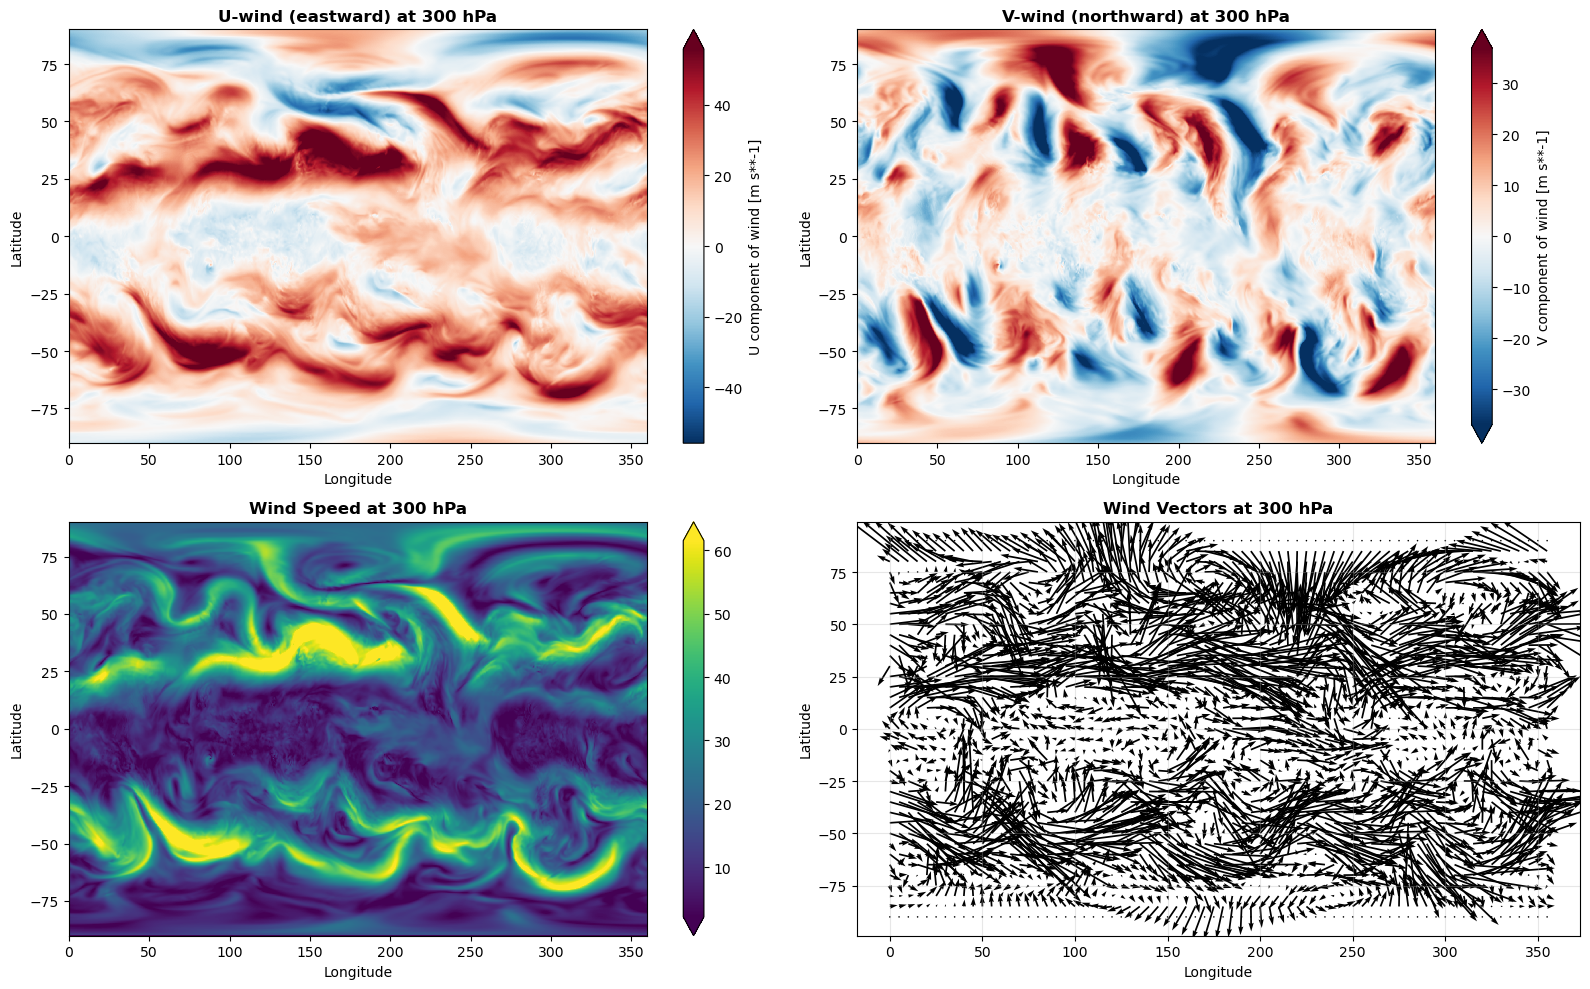

In [6]:
# Plot wind field at first time step
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# U-wind
u_wind.isel(valid_time=0).plot(ax=axes[0,0], cmap='RdBu_r', robust=True)
axes[0,0].set_title(f'U-wind (eastward) at {pressure_level} hPa', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

# V-wind
v_wind.isel(valid_time=0).plot(ax=axes[0,1], cmap='RdBu_r', robust=True)
axes[0,1].set_title(f'V-wind (northward) at {pressure_level} hPa', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Longitude')
axes[0,1].set_ylabel('Latitude')

# Wind speed
wind_speed = np.sqrt(u_wind.isel(valid_time=0)**2 + v_wind.isel(valid_time=0)**2)
wind_speed.plot(ax=axes[1,0], cmap='viridis', robust=True)
axes[1,0].set_title(f'Wind Speed at {pressure_level} hPa', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

# Subsample for quiver plot
skip = 20
axes[1,1].quiver(ds_850.longitude.values[::skip], 
                 ds_850.latitude.values[::skip],
                 u_wind.isel(valid_time=0).values[::skip, ::skip],
                 v_wind.isel(valid_time=0).values[::skip, ::skip],
                 scale=500)
axes[1,1].set_title(f'Wind Vectors at {pressure_level} hPa', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Longitude')
axes[1,1].set_ylabel('Latitude')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Setup Lagrangian Trajectory Integration

Following the paper:
- Integration: 4th-order Runge-Kutta with Δt = 1.5 hours
- Coordinates: (longitude, latitude, pressure)
- Interpolation: Multilinear in time and space

In [14]:
class WindFieldInterpolator:
    """Interpolator for wind field data"""
    
    def __init__(self, u_wind, v_wind, times, lats, lons):
        """
        Initialize wind field interpolator
        
        Parameters:
        -----------
        u_wind : xarray.DataArray
            Eastward wind component (time, lat, lon)
        v_wind : xarray.DataArray
            Northward wind component (time, lat, lon)
        times : array
            Time coordinates in hours
        lats : array
            Latitude coordinates
        lons : array
            Longitude coordinates
        """
        self.u_wind = u_wind.values
        self.v_wind = v_wind.values
        self.times = times
        self.lats = lats
        self.lons = lons
        
        # Create interpolators
        self.u_interp = RegularGridInterpolator(
            (times, lats, lons), self.u_wind, 
            method='linear', bounds_error=False, fill_value=0
        )
        self.v_interp = RegularGridInterpolator(
            (times, lats, lons), self.v_wind,
            method='linear', bounds_error=False, fill_value=0
        )
        
        # Earth's mean radius (km)
        self.R_earth = 6371.0
    
    def __call__(self, t, pos):
        """
        Compute velocity at given position and time
        
        Parameters:
        -----------
        t : float
            Time in hours
        pos : array [lon, lat]
            Position in degrees
        
        Returns:
        --------
        velocity : array [dlon/dt, dlat/dt]
            Velocity in degrees per hour
        """
        lon, lat = pos
        
        # Ensure longitude is in [0, 360]
        lon = lon % 360
        
        # Ensure latitude is in [-90, 90]
        lat = np.clip(lat, -90, 90)
        
        # Interpolate wind components (m/s)
        u = self.u_interp([t, lat, lon])[0]
        v = self.v_interp([t, lat, lon])[0]
        
        # Convert to degrees per hour
        # dlon/dt = u / (R * cos(lat)) * (180/π) * 3600
        # dlat/dt = v / R * (180/π) * 3600
        lat_rad = np.deg2rad(lat)
        dlon_dt = (u / (self.R_earth * 1000 * np.cos(lat_rad))) * (180/np.pi) * 3600
        dlat_dt = (v / (self.R_earth * 1000)) * (180/np.pi) * 3600
        
        return np.array([dlon_dt, dlat_dt])

print("✅ Wind field interpolator class defined")

✅ Wind field interpolator class defined


## 5. Initialize Particle Grid

Following the paper: 0.35° spacing (we'll use a coarser grid for testing)

In [15]:
# For testing, use a smaller domain and coarser resolution
# Full paper: global coverage with 0.35° spacing

lon_min, lon_max = 60, 300  # 170E to 100W (going eastward)
lat_min, lat_max = 0, 70   # 0N to 70N

# Grid spacing (degrees) - matching your requirement
grid_spacing = 0.75  # 0.25° resolution

# Create particle grid
lons_grid = np.arange(lon_min, lon_max, grid_spacing)
lats_grid = np.arange(lat_min, lat_max, grid_spacing)

lon_mesh, lat_mesh = np.meshgrid(lons_grid, lats_grid)
initial_positions = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

print(f"✅ Particle grid initialized:")
print(f"  - Domain: {lon_min}°E to {lon_max}°E, {lat_min}°N to {lat_max}°N")
print(f"  - Grid spacing: {grid_spacing}°")
print(f"  - Number of particles: {len(initial_positions)}")
print(f"  - Grid dimensions: {len(lats_grid)} x {len(lons_grid)}")

✅ Particle grid initialized:
  - Domain: 60°E to 300°E, 0°N to 70°N
  - Grid spacing: 0.75°
  - Number of particles: 30080
  - Grid dimensions: 94 x 320


## 6. Compute Lagrangian Trajectories

Integrate particle trajectories forward in time using 4th-order Runge-Kutta

In [16]:
# Setup time parameters
# START TIME INDEX - Change this to start from a different timestep
START_TIME_IDX = 4  # Start from 4th timestep instead of 0

# Convert time to hours since the START timestep
time_ref = ds_850.valid_time.values[START_TIME_IDX]
times_hours = np.array([(t - time_ref).astype('timedelta64[h]').astype(float) 
                        for t in ds_850.valid_time.values])

# Integration time (paper uses τ = 5 days for optimal results)
tau_days = 3.0  # Using 3 days for integration
tau_hours = tau_days * 24

# Check if we have enough data for FORWARD integration
max_forward_time = times_hours[-1]  # Hours from START_TIME_IDX to end
if tau_hours > max_forward_time:
    tau_hours = max_forward_time
    print(f"⚠️  Forward integration limited to {tau_hours} hours ({tau_hours/24:.1f} days)")

# Check if we have enough data for BACKWARD integration
max_backward_time = abs(times_hours[0])  # Hours from START_TIME_IDX to beginning
if tau_hours > max_backward_time:
    print(f"⚠️  Backward integration limited to {max_backward_time} hours ({max_backward_time/24:.1f} days)")

print(f"\n📍 Trajectory integration setup:")
print(f"  - Starting timestep: {START_TIME_IDX} ({ds_850.valid_time.values[START_TIME_IDX]})")
print(f"  - Time reference: t=0 at timestep {START_TIME_IDX}")
print(f"  - Integration time τ: {tau_hours} hours ({tau_hours/24:.1f} days)")
print(f"  - Available time range: {times_hours[0]:.1f} to {times_hours[-1]:.1f} hours")
print(f"  - Can integrate forward: {max_forward_time:.1f} hours ({max_forward_time/24:.1f} days)")
print(f"  - Can integrate backward: {max_backward_time:.1f} hours ({max_backward_time/24:.1f} days)")
print(f"  - Time resolution: {np.diff(ds_850.valid_time.values)[0].astype('timedelta64[h]').astype(float):.1f} hours")

⚠️  Backward integration limited to 24.0 hours (1.0 days)

📍 Trajectory integration setup:
  - Starting timestep: 4 (2022-12-23T00:00:00.000000000)
  - Time reference: t=0 at timestep 4
  - Integration time τ: 72.0 hours (3.0 days)
  - Available time range: -24.0 to 138.0 hours
  - Can integrate forward: 138.0 hours (5.8 days)
  - Can integrate backward: 24.0 hours (1.0 days)
  - Time resolution: 6.0 hours


In [17]:
# Initialize wind field interpolator
wind_interpolator = WindFieldInterpolator(
    u_wind, v_wind,
    times_hours,
    ds_850.latitude.values,
    ds_850.longitude.values
)

# Function to integrate single trajectory
def integrate_trajectory(initial_pos, t0, t_final, wind_interp):
    """
    Integrate a single particle trajectory
    
    Parameters:
    -----------
    initial_pos : array [lon, lat]
        Initial position
    t0 : float
        Initial time (hours)
    t_final : float
        Final time (hours)
    wind_interp : WindFieldInterpolator
        Wind field interpolator
    
    Returns:
    --------
    final_pos : array [lon, lat]
        Final position
    """
    try:
        # Use RK45 (4th-order Runge-Kutta)
        sol = solve_ivp(
            wind_interp,
            (t0, t_final),
            initial_pos,
            method='RK45',
            max_step=1.5,  # Paper uses 1.5 hour time step
            rtol=1e-6,
            atol=1e-8
        )
        
        if sol.success:
            return sol.y[:, -1]  # Return final position
        else:
            return initial_pos  # Return initial position if integration failed
    except:
        return initial_pos

print("✅ Trajectory integration functions ready")

✅ Trajectory integration functions ready


In [ ]:
# Integrate trajectories for all particles
print("🚀 Starting trajectory integration...")
print(f"   Integrating {len(initial_positions)} particles")

final_positions = np.zeros_like(initial_positions)

# Progress tracking
from tqdm.auto import tqdm

# IMPORTANT: Start from t=0 (which corresponds to START_TIME_IDX) and integrate forward
for i, init_pos in enumerate(tqdm(initial_positions, desc="Integrating trajectories")):
    final_positions[i] = integrate_trajectory(
        init_pos,
        0.0,              # Start at t=0 (which is START_TIME_IDX in actual time)
        tau_hours,        # Integrate forward to t=tau_hours
        wind_interpolator
    )

print("✅ Trajectory integration complete!")
print(f"  - Initial time: t=0 (timestep {START_TIME_IDX}, {ds_850.valid_time.values[START_TIME_IDX]})")
print(f"  - Final time: t={tau_hours}h (timestep {START_TIME_IDX + int(tau_hours/6)}, approx {ds_850.valid_time.values[min(START_TIME_IDX + int(tau_hours/6), 27)]})")

🚀 Starting trajectory integration...
   Integrating 30080 particles


Integrating trajectories:   0%|          | 0/30080 [00:00<?, ?it/s]

## 7. Visualize Trajectories

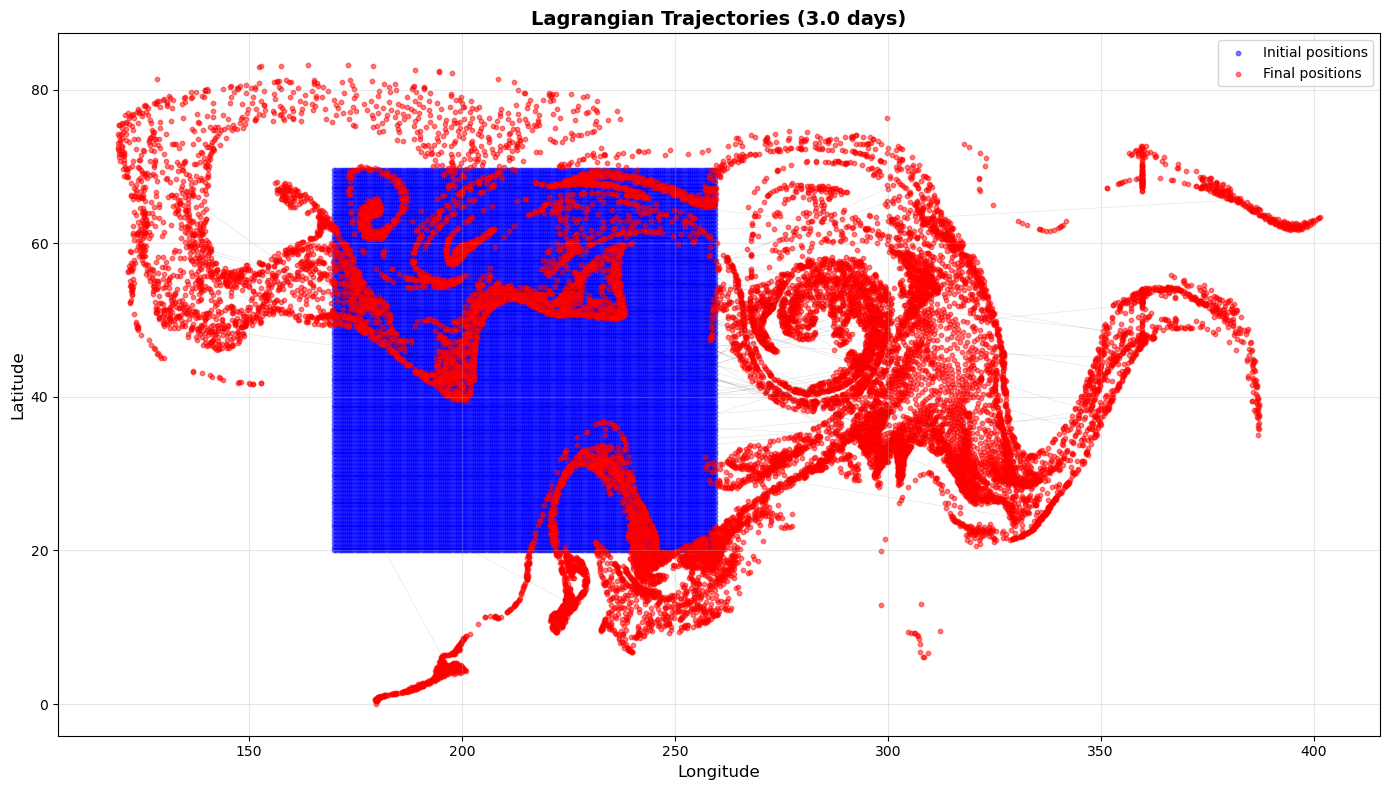

✅ Trajectory visualization saved


In [12]:
# Plot initial and final positions
fig, ax = plt.subplots(figsize=(14, 8))

# Plot initial positions
ax.scatter(initial_positions[:, 0], initial_positions[:, 1], 
           c='blue', s=10, alpha=0.5, label='Initial positions')

# Plot final positions
ax.scatter(final_positions[:, 0], final_positions[:, 1], 
           c='red', s=10, alpha=0.5, label='Final positions')

# Plot some trajectories
n_traj_plot = min(100, len(initial_positions))
indices = np.random.choice(len(initial_positions), n_traj_plot, replace=False)
for idx in indices:
    ax.plot([initial_positions[idx, 0], final_positions[idx, 0]],
            [initial_positions[idx, 1], final_positions[idx, 1]],
            'k-', alpha=0.1, linewidth=0.5)

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title(f'Lagrangian Trajectories ({tau_hours/24:.1f} days)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(data_path / 'trajectories.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Trajectory visualization saved")

## 8. Calculate Flow Map Gradient (∇Φ)

Compute the gradient of the flow map using finite differences

In [13]:
def compute_flow_map_gradient(initial_grid_shape, final_positions, grid_spacing_deg):
    """
    Compute flow map gradient using finite differences
    
    Parameters:
    -----------
    initial_grid_shape : tuple (n_lat, n_lon)
        Shape of initial particle grid
    final_positions : array (n_particles, 2)
        Final positions [lon, lat]
    grid_spacing_deg : float
        Grid spacing in degrees
    
    Returns:
    --------
    grad_phi : array (n_particles, 2, 2)
        Flow map gradient [dlon/dlon0, dlon/dlat0; dlat/dlon0, dlat/dlat0]
    """
    n_lat, n_lon = initial_grid_shape
    final_lon = final_positions[:, 0].reshape(n_lat, n_lon)
    final_lat = final_positions[:, 1].reshape(n_lat, n_lon)
    
    # Initialize gradient array
    grad_phi = np.zeros((n_lat, n_lon, 2, 2))
    
    # Central differences for interior points
    for i in range(1, n_lat-1):
        for j in range(1, n_lon-1):
            # ∂(final_lon)/∂(init_lon)
            grad_phi[i, j, 0, 0] = (final_lon[i, j+1] - final_lon[i, j-1]) / (2 * grid_spacing_deg)
            
            # ∂(final_lon)/∂(init_lat)
            grad_phi[i, j, 0, 1] = (final_lon[i+1, j] - final_lon[i-1, j]) / (2 * grid_spacing_deg)
            
            # ∂(final_lat)/∂(init_lon)
            grad_phi[i, j, 1, 0] = (final_lat[i, j+1] - final_lat[i, j-1]) / (2 * grid_spacing_deg)
            
            # ∂(final_lat)/∂(init_lat)
            grad_phi[i, j, 1, 1] = (final_lat[i+1, j] - final_lat[i-1, j]) / (2 * grid_spacing_deg)
    
    # Forward/backward differences for boundary points
    # Left boundary (j=0)
    grad_phi[:, 0, 0, 0] = (final_lon[:, 1] - final_lon[:, 0]) / grid_spacing_deg
    grad_phi[:, 0, 1, 0] = (final_lat[:, 1] - final_lat[:, 0]) / grid_spacing_deg
    
    # Right boundary (j=-1)
    grad_phi[:, -1, 0, 0] = (final_lon[:, -1] - final_lon[:, -2]) / grid_spacing_deg
    grad_phi[:, -1, 1, 0] = (final_lat[:, -1] - final_lat[:, -2]) / grid_spacing_deg
    
    # Bottom boundary (i=0)
    grad_phi[0, :, 0, 1] = (final_lon[1, :] - final_lon[0, :]) / grid_spacing_deg
    grad_phi[0, :, 1, 1] = (final_lat[1, :] - final_lat[0, :]) / grid_spacing_deg
    
    # Top boundary (i=-1)
    grad_phi[-1, :, 0, 1] = (final_lon[-1, :] - final_lon[-2, :]) / grid_spacing_deg
    grad_phi[-1, :, 1, 1] = (final_lat[-1, :] - final_lat[-2, :]) / grid_spacing_deg
    
    return grad_phi

# Compute flow map gradient
grid_shape = (len(lats_grid), len(lons_grid))
grad_phi = compute_flow_map_gradient(grid_shape, final_positions, grid_spacing)

print(f"✅ Flow map gradient computed")
print(f"  - Shape: {grad_phi.shape}")

✅ Flow map gradient computed
  - Shape: (100, 180, 2, 2)


## 9. Calculate FTLE Field

Following Equation (2) from the paper:
$$\lambda(\tau, t_0, r_0) = \frac{1}{|\tau|} \log\sqrt{\mu_{\max}(\tilde{C})}$$

where $\tilde{C}$ is the Cauchy-Green deformation tensor (Equation 3)

In [14]:
def compute_cauchy_green_tensor(grad_phi, latitude):
    """
    Compute Cauchy-Green deformation tensor on sphere
    
    Parameters:
    -----------
    grad_phi : array (..., 2, 2)
        Flow map gradient
    latitude : array
        Latitude values (degrees)
    
    Returns:
    --------
    C : array (..., 2, 2)
        Cauchy-Green tensor
    """
    # Metric tensor for spherical coordinates
    lat_rad = np.deg2rad(latitude)
    
    # Reshape for broadcasting
    n_lat, n_lon = grad_phi.shape[:2]
    lat_2d = lat_rad[:, np.newaxis]
    
    # Metric tensor G (diagonal for spherical coordinates)
    # G = diag([cos²(θ), 1])
    G = np.zeros((n_lat, n_lon, 2, 2))
    G[:, :, 0, 0] = np.cos(lat_2d) ** 2
    G[:, :, 1, 1] = 1.0
    
    # Cauchy-Green tensor: C = (∇Φ)^T · G · (∇Φ)
    C = np.zeros_like(grad_phi)
    for i in range(n_lat):
        for j in range(n_lon):
            grad_phi_T = grad_phi[i, j].T
            C[i, j] = grad_phi_T @ G[i, j] @ grad_phi[i, j]
    
    return C

def compute_ftle(grad_phi, latitude, tau_hours):
    """
    Compute FTLE field
    
    Parameters:
    -----------
    grad_phi : array (n_lat, n_lon, 2, 2)
        Flow map gradient
    latitude : array (n_lat,)
        Latitude values
    tau_hours : float
        Integration time in hours
    
    Returns:
    --------
    ftle : array (n_lat, n_lon)
        FTLE field (units: 1/day)
    """
    n_lat, n_lon = grad_phi.shape[:2]
    
    # Compute Cauchy-Green tensor
    C = compute_cauchy_green_tensor(grad_phi, latitude)
    
    # Compute maximum eigenvalue
    ftle = np.zeros((n_lat, n_lon))
    
    for i in range(n_lat):
        for j in range(n_lon):
            eigenvalues = np.linalg.eigvals(C[i, j])
            max_eigenvalue = np.max(np.real(eigenvalues))
            
            # FTLE = (1/|τ|) * log(sqrt(λ_max))
            if max_eigenvalue > 0:
                ftle[i, j] = (1 / abs(tau_hours)) * np.log(np.sqrt(max_eigenvalue))
            else:
                ftle[i, j] = 0
    
    # Convert from 1/hour to 1/day
    ftle = ftle * 24
    
    return ftle

# Calculate FTLE
print("🧮 Computing FTLE field...")
ftle_field = compute_ftle(grad_phi, lats_grid, tau_hours)

print(f"✅ FTLE calculation complete!")
print(f"  - FTLE shape: {ftle_field.shape}")
print(f"  - FTLE range: [{np.min(ftle_field):.4f}, {np.max(ftle_field):.4f}] day⁻¹")
print(f"  - Mean FTLE: {np.mean(ftle_field):.4f} day⁻¹")

🧮 Computing FTLE field...
✅ FTLE calculation complete!
  - FTLE shape: (100, 180)
  - FTLE range: [-0.9202, 1.6934] day⁻¹
  - Mean FTLE: 0.6924 day⁻¹


## 10. Visualize FTLE Field

Higher FTLE values indicate regions of strong stretching and mixing

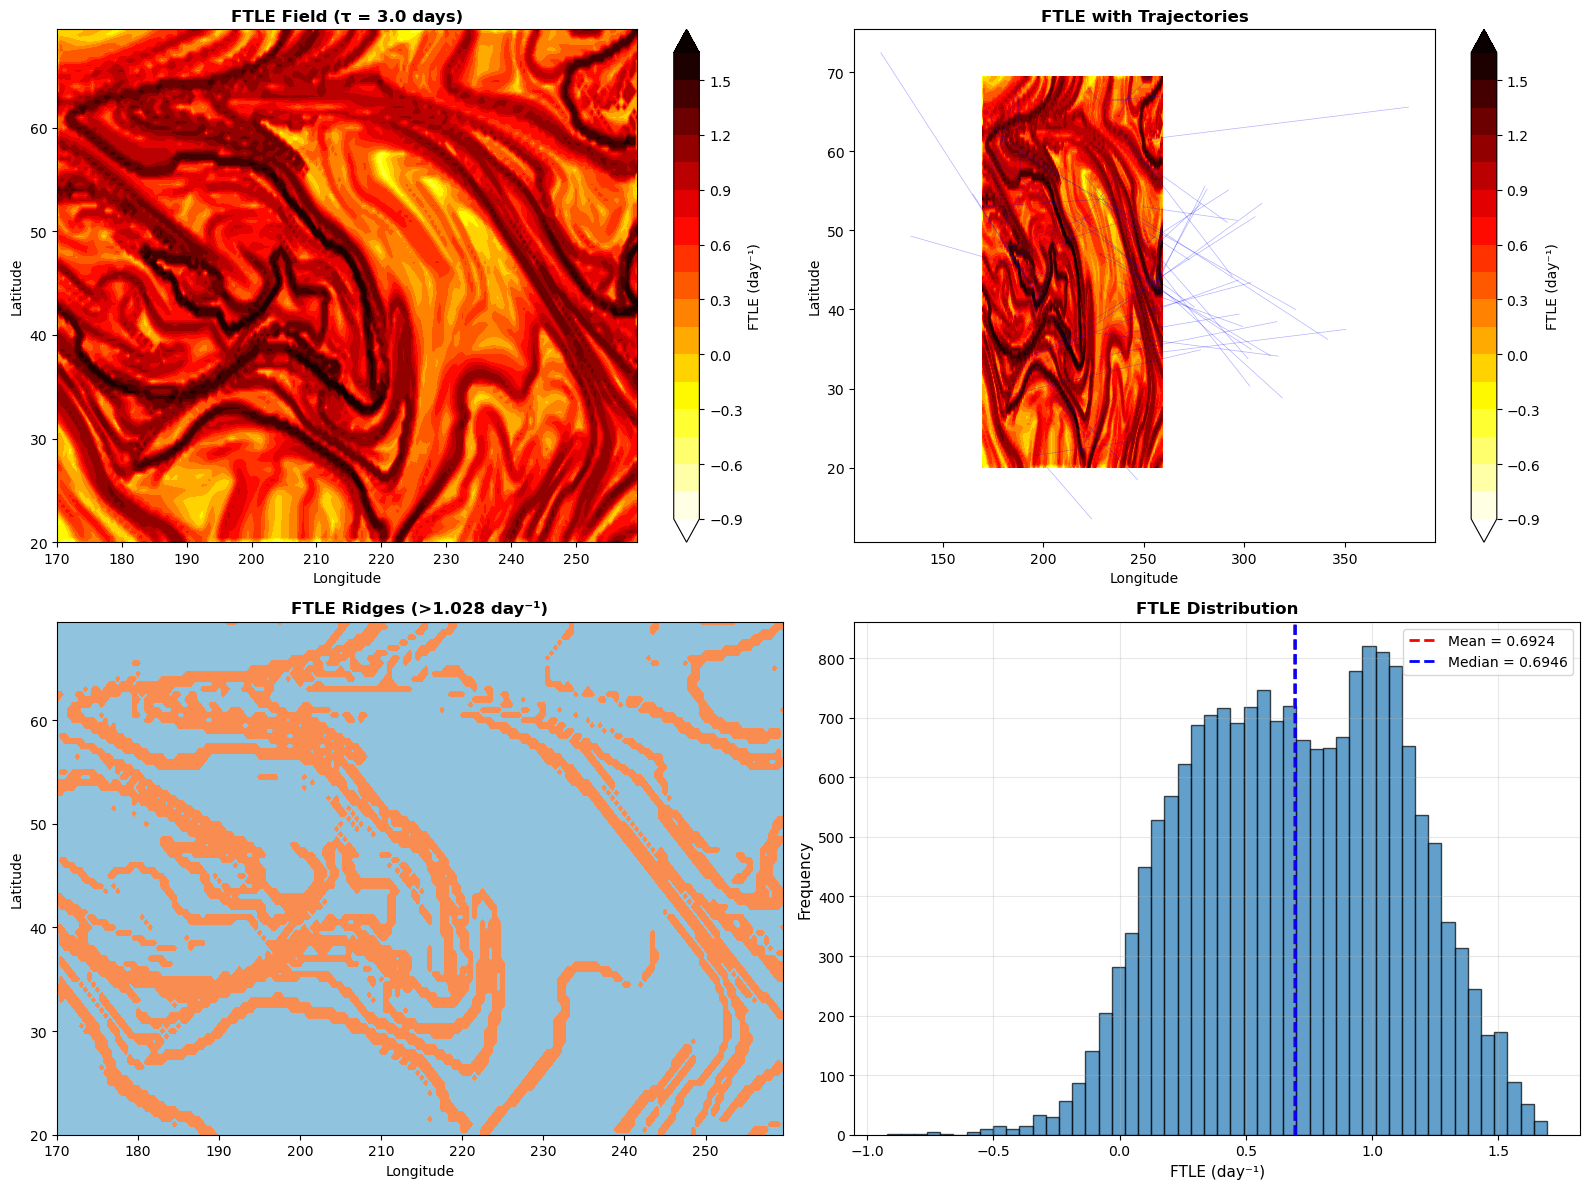

✅ FTLE visualization saved


In [15]:
# Create FTLE visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# FTLE field
im1 = axes[0, 0].contourf(lons_grid, lats_grid, ftle_field, 
                          levels=20, cmap='hot_r', extend='both')
axes[0, 0].set_title(f'FTLE Field (τ = {tau_hours/24:.1f} days)', 
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Longitude')
axes[0, 0].set_ylabel('Latitude')
plt.colorbar(im1, ax=axes[0, 0], label='FTLE (day⁻¹)')

# FTLE with trajectories overlay
im2 = axes[0, 1].contourf(lons_grid, lats_grid, ftle_field, 
                          levels=20, cmap='hot_r', extend='both')
# Overlay some trajectories
for idx in indices[:50]:
    axes[0, 1].plot([initial_positions[idx, 0], final_positions[idx, 0]],
                    [initial_positions[idx, 1], final_positions[idx, 1]],
                    'b-', alpha=0.3, linewidth=0.5)
axes[0, 1].set_title('FTLE with Trajectories', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Longitude')
axes[0, 1].set_ylabel('Latitude')
plt.colorbar(im2, ax=axes[0, 1], label='FTLE (day⁻¹)')

# FTLE ridges (high values indicate barriers to mixing)
ftle_threshold = np.percentile(ftle_field, 75)
ftle_ridges = ftle_field > ftle_threshold
axes[1, 0].contourf(lons_grid, lats_grid, ftle_ridges, 
                    levels=[0, 0.5, 1], cmap='RdYlBu_r')
axes[1, 0].set_title(f'FTLE Ridges (>{ftle_threshold:.3f} day⁻¹)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Longitude')
axes[1, 0].set_ylabel('Latitude')

# FTLE histogram
axes[1, 1].hist(ftle_field.ravel(), bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(np.mean(ftle_field), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean = {np.mean(ftle_field):.4f}')
axes[1, 1].axvline(np.median(ftle_field), color='blue', linestyle='--', 
                   linewidth=2, label=f'Median = {np.median(ftle_field):.4f}')
axes[1, 1].set_xlabel('FTLE (day⁻¹)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('FTLE Distribution', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(data_path / 'ftle_field.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ FTLE visualization saved")

## 11. Comparison with Wind Speed

Compare FTLE with wind speed to understand the relationship

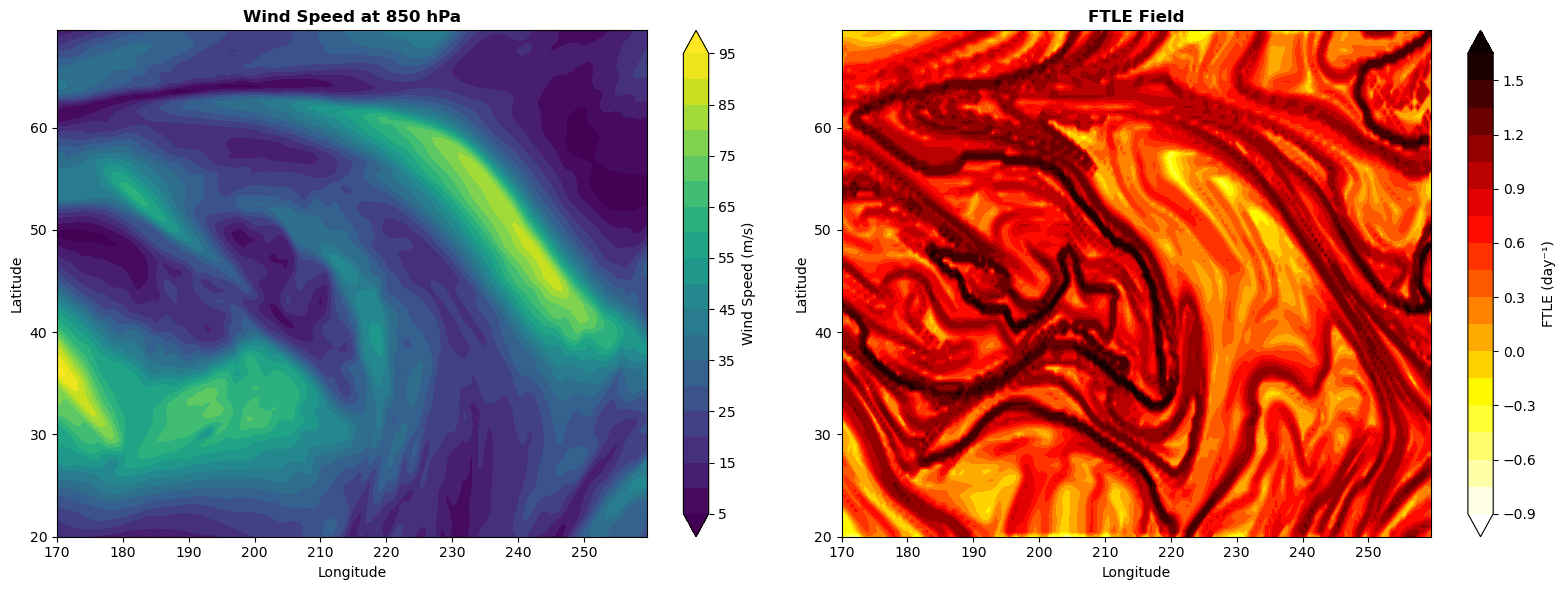

✅ Wind speed comparison saved


In [16]:
# Interpolate wind speed to FTLE grid
from scipy.interpolate import griddata

# Get wind speed at initial time
u_0 = u_wind.isel(valid_time=0).values
v_0 = v_wind.isel(valid_time=0).values
wind_speed_full = np.sqrt(u_0**2 + v_0**2)

# Create meshgrid for interpolation
lon_full, lat_full = np.meshgrid(ds_850.longitude.values, ds_850.latitude.values)
points = np.column_stack([lon_full.ravel(), lat_full.ravel()])
values = wind_speed_full.ravel()

# Interpolate to FTLE grid
lon_ftle_mesh, lat_ftle_mesh = np.meshgrid(lons_grid, lats_grid)
points_ftle = np.column_stack([lon_ftle_mesh.ravel(), lat_ftle_mesh.ravel()])
wind_speed_interp = griddata(points, values, points_ftle, method='linear')
wind_speed_grid = wind_speed_interp.reshape(len(lats_grid), len(lons_grid))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Wind speed
im1 = axes[0].contourf(lons_grid, lats_grid, wind_speed_grid, 
                       levels=20, cmap='viridis', extend='both')
axes[0].set_title('Wind Speed at 850 hPa', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
plt.colorbar(im1, ax=axes[0], label='Wind Speed (m/s)')

# FTLE
im2 = axes[1].contourf(lons_grid, lats_grid, ftle_field, 
                       levels=20, cmap='hot_r', extend='both')
axes[1].set_title('FTLE Field', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
plt.colorbar(im2, ax=axes[1], label='FTLE (day⁻¹)')

plt.tight_layout()
plt.savefig(data_path / 'ftle_vs_windspeed.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Wind speed comparison saved")

## 14. Figure 1 Style Visualization - Paper Replication

Recreate Figure 1 from Garaboa-Paz et al. (2017) showing:
- Filamentary FTLE structures with blue colormap
- High contrast visualization of Lagrangian coherent structures

In [20]:
import matplotlib.colors as colors
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

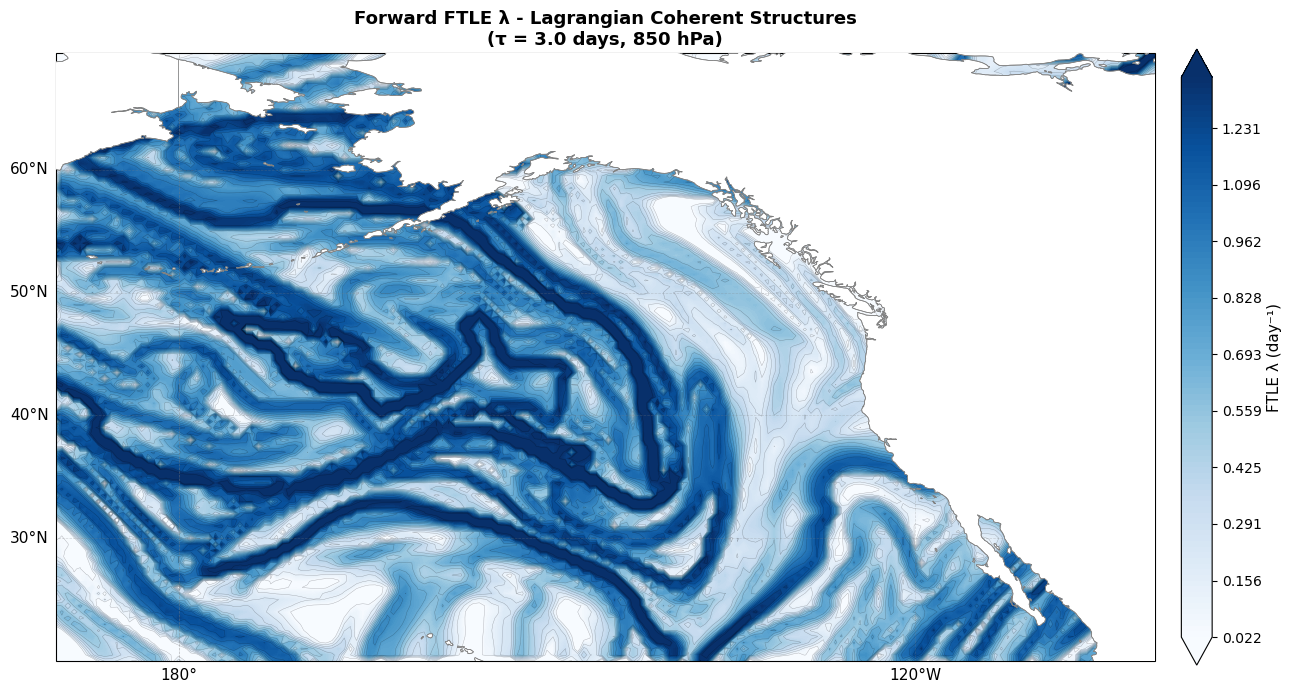

✅ Figure 1(a) style visualization created


In [21]:
# Use finer contour levels for filamentary structure
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Create custom colormap: white (low) to dark blue (high)
cmap = cm.get_cmap('Blues')  # Blues: white (low) to dark blue (high)

# Normalize FTLE values for better contrast
vmin = np.percentile(ftle_field, 5)  # Clip lower 5%
vmax = np.percentile(ftle_field, 95)  # Clip upper 5%

# Create filled contours with many levels for smooth filamentary structure
levels = np.linspace(vmin, vmax, 100)
cf = ax.contourf(lons_grid, lats_grid, ftle_field,
               levels=levels, cmap=cmap,
               vmin=vmin, vmax=vmax, extend='both',
               transform=ccrs.PlateCarree())

# Add contour lines for structure emphasis
contour_levels = np.linspace(vmin, vmax, 15)
ax.contour(lons_grid, lats_grid, ftle_field,
         levels=contour_levels, colors='black',
         linewidths=0.3, alpha=0.3,
         transform=ccrs.PlateCarree())

# Add land mask (continents in white/light gray)
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=0.5, zorder=3)

# Add coastlines
ax.coastlines(resolution='50m', linewidth=0.5, color='gray', zorder=4)

# Set extent to EXACTLY your FTLE domain: 170E to 100W (260), 20N to 70N
# ax.set_extent([170, 260, 20, 70], crs=ccrs.PlateCarree())


# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 11}
gl.ylabel_style = {'size': 11}

# Title
ax.set_title(f'Forward FTLE λ - Lagrangian Coherent Structures\n(τ = {tau_hours/24:.1f} days, {pressure_level} hPa)',
           fontsize=13, fontweight='bold')

# Colorbar
cbar = plt.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, shrink=0.8)
cbar.set_label('FTLE λ (day⁻¹)', fontsize=11)

plt.tight_layout()
# plt.savefig(data_path / 'ftle_figure1a_style.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure 1(a) style visualization created")

In [44]:
# # Enhanced version with better contrast for filamentary structures
# # Apply edge enhancement to emphasize Lagrangian Coherent Structures
# from scipy.ndimage import gaussian_gradient_magnitude

# # Compute gradient magnitude to highlight ridges
# ftle_gradient = gaussian_gradient_magnitude(ftle_field, sigma=0.5)

# fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# # Left: Original FTLE with blue colormap
# cmap_blue = cm.get_cmap('Blues_r')
# vmin = np.percentile(ftle_field, 5)
# vmax = np.percentile(ftle_field, 95)

# cf1 = axes[0].contourf(lons_grid, lats_grid, ftle_field, 
#                        levels=np.linspace(vmin, vmax, 100), 
#                        cmap=cmap_blue, vmin=vmin, vmax=vmax, extend='both')
# axes[0].contour(lons_grid, lats_grid, ftle_field, 
#                 levels=np.linspace(vmin, vmax, 20), 
#                 colors='black', linewidths=0.4, alpha=0.4)
# axes[0].set_xlabel('Longitude', fontsize=12)
# axes[0].set_ylabel('Latitude', fontsize=12)
# axes[0].set_title('FTLE Field - Filamentary Structures\n(darker = stronger mixing)', 
#                   fontsize=12, fontweight='bold')
# axes[0].grid(True, alpha=0.2)
# cbar1 = plt.colorbar(cf1, ax=axes[0])
# cbar1.set_label('FTLE (day⁻¹)', fontsize=11)

# # Right: FTLE gradient (Lagrangian Coherent Structure ridges)
# cf2 = axes[1].contourf(lons_grid, lats_grid, ftle_gradient, 
#                        levels=50, cmap='hot', extend='both')
# axes[1].set_xlabel('Longitude', fontsize=12)
# axes[1].set_ylabel('Latitude', fontsize=12)
# axes[1].set_title('FTLE Ridges - Lagrangian Coherent Structures\n(bright = transport barriers)', 
#                   fontsize=12, fontweight='bold')
# axes[1].grid(True, alpha=0.2)
# cbar2 = plt.colorbar(cf2, ax=axes[1])
# cbar2.set_label('Gradient Magnitude (day⁻¹/deg)', fontsize=11)

# plt.tight_layout()
# plt.savefig(data_path / 'ftle_enhanced_structures.png', dpi=300, bbox_inches='tight')
# plt.show()

# print("✅ Enhanced FTLE structures visualization created")
# print(f"\n💡 Interpretation:")
# print(f"   - Left: Filamentary patterns show fluid stretching and folding")
# print(f"   - Right: Bright ridges are Lagrangian Coherent Structures (LCS)")
# print(f"   - LCS act as transport barriers separating different air masses")

In [23]:
# ========================================
# BACKWARD FTLE CALCULATION
# ========================================

print("🚀 Starting BACKWARD trajectory integration...")
print(f"   Integrating {len(initial_positions)} particles backward in time")

final_positions_backward = np.zeros_like(initial_positions)

# For backward integration, we need to reverse the wind field direction
# OR start from the last time and integrate backward

# Method 1: Reverse time integration
class BackwardWindInterpolator(WindFieldInterpolator):
  """Wind field interpolator for backward integration (reverses velocity)"""

  def __call__(self, t, pos):
      """Returns negative velocity for backward integration"""
      velocity = super().__call__(t, pos)
      return -velocity  # Reverse the flow

# Create backward wind interpolator
wind_interpolator_backward = BackwardWindInterpolator(
  u_wind, v_wind,
  times_hours,
  ds_850.latitude.values,
  ds_850.longitude.values
)

# Integrate backward from initial time
for i, init_pos in enumerate(tqdm(initial_positions, desc="Backward trajectories")):
  final_positions_backward[i] = integrate_trajectory(
      init_pos,
      times_hours[0],              # Start at t=0
      times_hours[0] + tau_hours,  # Integrate to t=tau (but with reversed velocity)
      wind_interpolator_backward   # Use backward interpolator
  )

print("✅ Backward trajectory integration complete!")

# Compute flow map gradient for backward FTLE
grad_phi_backward = compute_flow_map_gradient(grid_shape, final_positions_backward, grid_spacing)
print("✅ Backward flow map gradient computed")

# Calculate backward FTLE
print("🧮 Computing backward FTLE field...")
ftle_field_backward = compute_ftle(grad_phi_backward, lats_grid, tau_hours)

print(f"✅ Backward FTLE calculation complete!")
print(f"  - Backward FTLE shape: {ftle_field_backward.shape}")
print(f"  - Backward FTLE range: [{np.min(ftle_field_backward):.4f}, {np.max(ftle_field_backward):.4f}] day⁻¹")
print(f"  - Mean backward FTLE: {np.mean(ftle_field_backward):.4f} day⁻¹")

🚀 Starting BACKWARD trajectory integration...
   Integrating 18000 particles backward in time


Backward trajectories:   0%|          | 0/18000 [00:00<?, ?it/s]

✅ Backward trajectory integration complete!
✅ Backward flow map gradient computed
🧮 Computing backward FTLE field...
✅ Backward FTLE calculation complete!
  - Backward FTLE shape: (100, 180)
  - Backward FTLE range: [-5.4779, 3.0695] day⁻¹
  - Mean backward FTLE: 0.6258 day⁻¹


In [25]:
# Your current results are FORWARD FTLE
ftle_field_forward = ftle_field.copy()
final_positions_forward = final_positions.copy()

print(f"\n📊 FTLE Summary:")
print(f"  Forward FTLE (repelling):  mean = {np.mean(ftle_field_forward):.4f} day⁻¹")
print(f"  Backward FTLE (attracting): mean = {np.mean(ftle_field_backward):.4f} day⁻¹")


📊 FTLE Summary:
  Forward FTLE (repelling):  mean = 0.8469 day⁻¹
  Backward FTLE (attracting): mean = 0.6258 day⁻¹


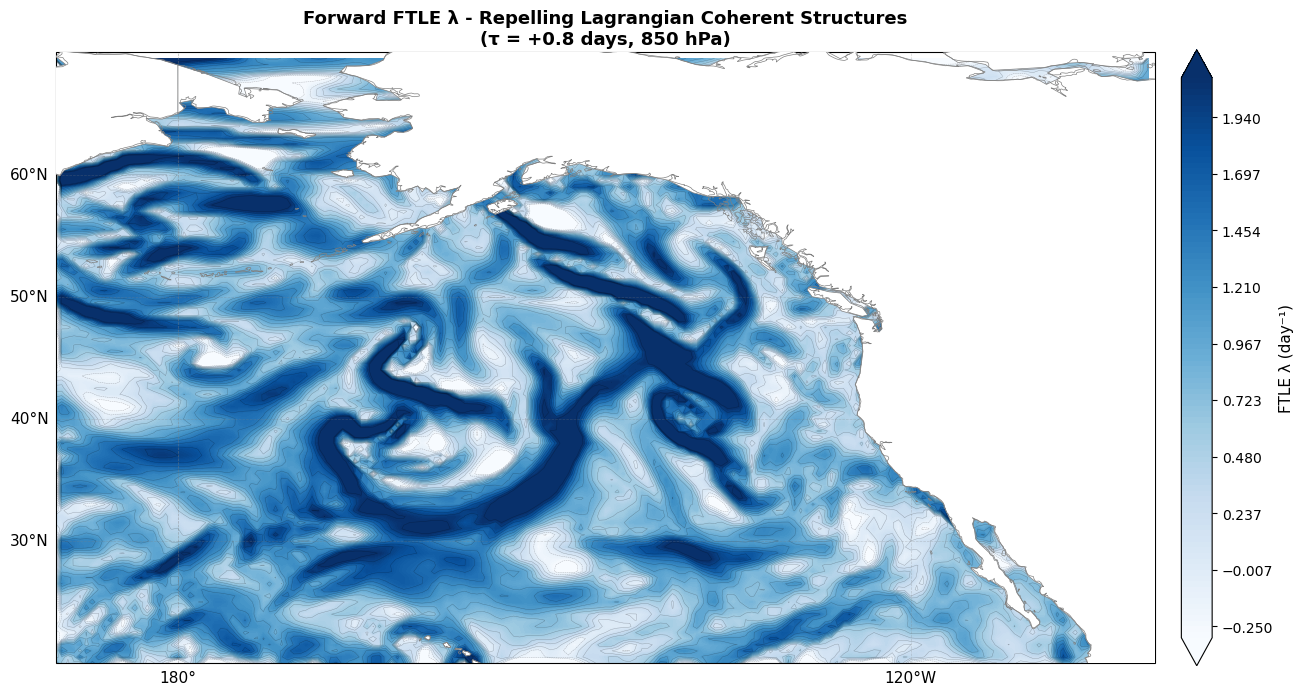

✅ Forward FTLE visualization created


In [26]:
# Create Figure 1(a) style plot - FORWARD FTLE with filamentary structures
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

cmap = cm.get_cmap('Blues')  # white (low) to dark blue (high)

vmin = np.percentile(ftle_field_forward, 5)
vmax = np.percentile(ftle_field_forward, 95)

levels = np.linspace(vmin, vmax, 100)
cf = ax.contourf(lons_grid, lats_grid, ftle_field_forward,
               levels=levels, cmap=cmap,
               vmin=vmin, vmax=vmax, extend='both',
               transform=ccrs.PlateCarree())

contour_levels = np.linspace(vmin, vmax, 15)
ax.contour(lons_grid, lats_grid, ftle_field_forward,
         levels=contour_levels, colors='black',
         linewidths=0.3, alpha=0.3,
         transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=0.5, zorder=3)
ax.coastlines(resolution='50m', linewidth=0.5, color='gray', zorder=4)
ax.set_extent([170, 260, 20, 70], crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 11}
gl.ylabel_style = {'size': 11}

# CORRECTED TITLE - Forward FTLE
ax.set_title(f'Forward FTLE λ - Repelling Lagrangian Coherent Structures\n(τ = +{tau_hours/24:.1f} days, 850 hPa)',
           fontsize=13, fontweight='bold')

cbar = plt.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, shrink=0.8)
cbar.set_label('FTLE λ (day⁻¹)', fontsize=11)

plt.tight_layout()
plt.savefig(data_path / 'ftle_forward.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Forward FTLE visualization created")

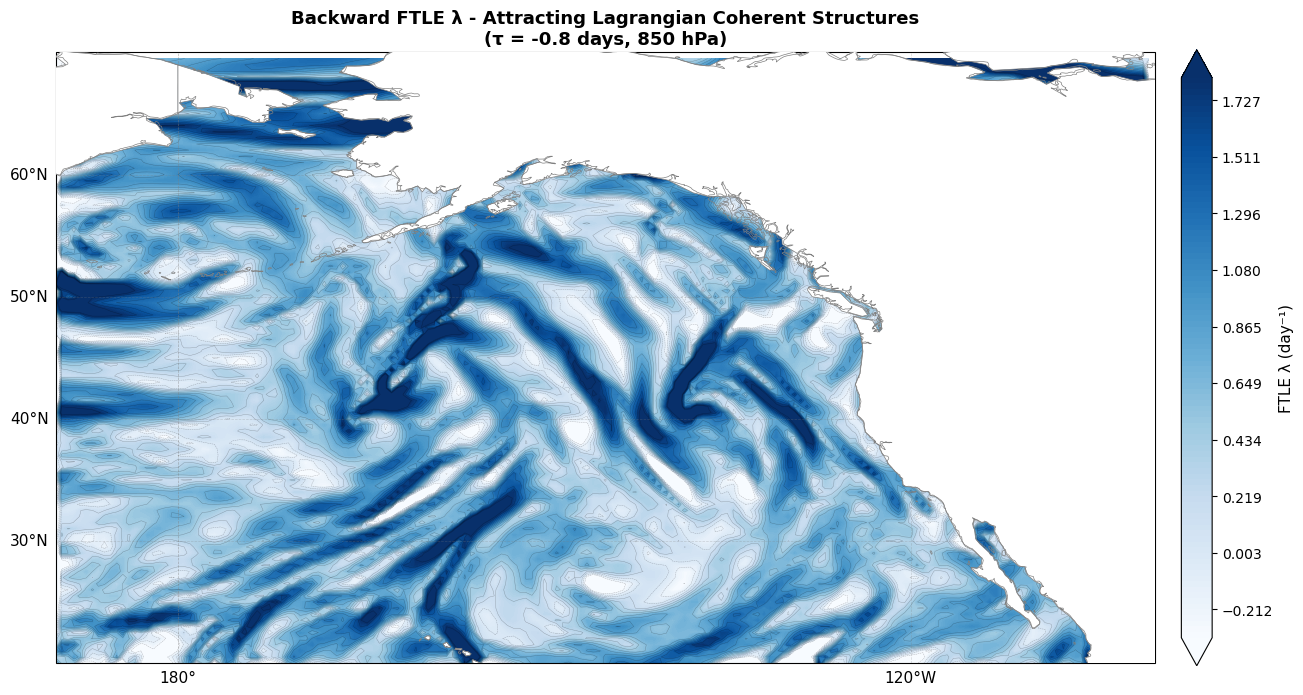

✅ Backwawrd FTLE visualization created


In [28]:
# Create Figure 1(a) style plot - FORWARD FTLE with filamentary structures
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

cmap = cm.get_cmap('Blues')  # white (low) to dark blue (high)

vmin = np.percentile(ftle_field_backward, 5)
vmax = np.percentile(ftle_field_backward, 95)

levels = np.linspace(vmin, vmax, 100)
cf = ax.contourf(lons_grid, lats_grid, ftle_field_backward,
               levels=levels, cmap=cmap,
               vmin=vmin, vmax=vmax, extend='both',
               transform=ccrs.PlateCarree())

contour_levels = np.linspace(vmin, vmax, 15)
ax.contour(lons_grid, lats_grid, ftle_field_backward,
         levels=contour_levels, colors='black',
         linewidths=0.3, alpha=0.3,
         transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=0.5, zorder=3)
ax.coastlines(resolution='50m', linewidth=0.5, color='gray', zorder=4)
ax.set_extent([170, 260, 20, 70], crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 11}
gl.ylabel_style = {'size': 11}

# CORRECTED TITLE - Forward FTLE
ax.set_title(f'Backward FTLE λ - Attracting Lagrangian Coherent Structures\n(τ = -{tau_hours/24:.1f} days, 850 hPa)',
           fontsize=13, fontweight='bold')

cbar = plt.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, shrink=0.8)
cbar.set_label('FTLE λ (day⁻¹)', fontsize=11)

plt.tight_layout()
# plt.savefig(data_path / 'ftle_backward.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Backwawrd FTLE visualization created")